In [3]:
import numpy as np
import matplotlib.pyplot as plt

Crearemos una red de neuronas LIF con sinapsis de tipo _conductancia_ con decaimiento exponencial. Entonces, las ecuaciones de la i-ésima neurona de la red son:

$$\frac{dV_i}{dt} =-\frac{V_i-E_i}{\tau_i} - g_{syn,i}(V_i-E_{syn}) + I_{ext}$$
$$\frac{dg_{syn,i}}{dt} = -\frac{g_{syn,i}}{\tau_{syn}} + \sum_{k \neq i}^{N}{W_{ik}C_{ik}\delta(V_k=V_{th})}  $$
$$V_{i,t}\geq V_{th} \Rightarrow  V_{i,t+1}=V_{reset}$$

$W_{ik}$ es el _peso sináptico_ desde la neurona $k$ a la neurona $i$, un número real que indica cuánto se incrementa la conductancia sináptica $g_{syn,i}$ por cada disparo de $k$. Por otro lado, $C$ es la _matriz de conectividad_ de la red, de manera que $C_{ik}=1$ si la neurona $k$ hace sinapsis sobre la neurona $i$. Colocar ambos términos de esta forma es redundante, pero en este caso se dejará así para enfatizar la diferencia entre ambos conceptos.

Ahora cada neurona tiene 2 variables, $V$ y $g_{syn}$

In [6]:
nLIF=5 #numero de neuronas a simular
Vreset=-70; Vrep=-60
#tau=[1.,.95,.93]; th=[-48,-46,-44] #Neuronas distintas   
#Neuronas idénticas
tau=1; th=-46

tau_syn=10; Esyn=0 # el potencial de reversión indica sinapsis excitatoria

def LIF(X,I):
    v,gsyn=X
    return np.array([-(v-Vrep)/tau - gsyn*(v-Esyn)+ I,
                     -gsyn/tau_syn])

Wsyn=0.02  #peso sináptico - igual para todos
#recordar que será siempre positivo porque son sinapsis de tipo conductancia

#Matriz de conectividad - aleatoria p=0.3
CM=np.random.binomial(1,0.3,(nLIF,nLIF))
CM[np.diag_indices_from(CM)]=0  #eliminar conexiones en la diagonal

#Matrix de conectividad - lattice
#CM=np.zeros((nLIF,nLIF))
#CM+=np.eye(nLIF,k=1)
#CM+=np.eye(nLIF,k=2)

Ioffset=12 #media del estímulo
noise=2 #desviacion estandar del ruido

tstop=100; dt=0.01
time=np.arange(0,tstop,dt)

v=-60*np.ones(nLIF) #La variable v tiene dimensión nLIF
n=np.zeros_like(v)
X=np.array([v,n])
X_t=np.zeros((len(time),2,nLIF))

spikes=[]

for i,t in enumerate(time):
    X_t[i]=X
    Istim=Ioffset+np.sqrt(noise/dt)*np.random.normal(size=nLIF) #distinta corriente en cada neurona
    X+=dt*LIF(X,Istim)
    
    if any(X[0]>=th):
        idx=np.where(X[0]>=th)[0]
        X[0,idx] = Vreset
        X[1] = X[1] + Wsyn*np.sum(CM[idx],0)
        for idx_i in idx:
            spikes.append([idx_i,t])

spikes=np.array(spikes)


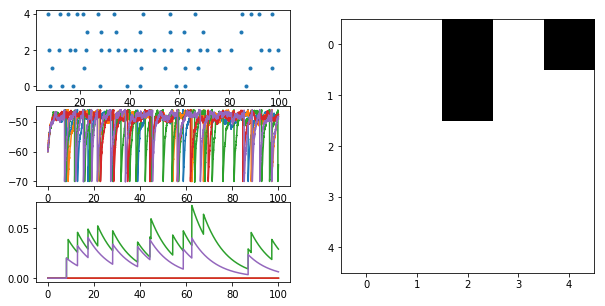

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(321)
plt.plot(spikes[:,1],spikes[:,0],'.')
plt.subplot(323)
plt.plot(time,X_t[:,0])
plt.subplot(325)
plt.plot(time,X_t[:,1])
plt.subplot(122)
plt.imshow(CM,cmap='gray_r')

A la red anterior le falta algo: __sinapsis inhibitorias__. Al estar trabajando con conductancias, se necesita una nueva variable para la conductancia inhibitoria.

$$\begin{align}
\frac{dV_i}{dt} &=-\frac{V_i-E_i}{\tau_i} - g_{exc,i}(V_i-E_{exc}) - g_{inh,i}(V_i-E_{inh}) + I_{ext} \\
\frac{dg_{exc,i}}{dt} &= -\frac{g_{exc,i}}{\tau_{exc}} + \sum_{k \neq i}^{N_{exc}}{W_{ik}C_{ik}\delta(V_k=V_{th})}  \\
\frac{dg_{inh,i}}{dt} &= -\frac{g_{inh,i}}{\tau_{inh}} + \sum_{k \neq i}^{N_{inh}}{W_{ik}C_{ik}\delta(V_k=V_{th})}
\end{align}$$
$$V_{i,t}\geq V_{th} \Rightarrow  V_{i,t+1}=V_{reset}$$

Notar que la suma de incrementos de conductancias excitatorias se hace solamente sobre la población $N_{exc}$ de neuronas excitatorias; mientras que lo mismo ocurre para la conductancia inhibitoria. En la práctica, esto se puede conseguir con una sola matriz $C$, en la cual se podrán especificar 'cuadrantes' exc->exc, exc->inh, etc.

In [ ]:
Vreset=-70; Vrep=-60
#tau=[1.,.95,.93]; th=[-48,-46,-44] #Neuronas distintas   
#Neuronas idénticas
tau=1; th=-46

tau_exc=5; Eexc=0 # el potencial de reversión indica sinapsis excitatoria
tau_inh=10; Einh=-70

def LIF(X,I):
    v,ge,gi=X
    return np.array([-(v-Vrep)/tau - ge*(v-Eexc) - gi*(v-Einh)+ I,
                     -ge / tau_exc,
                     -gi /tau_inh])

#recordar que será siempre positivo porque son sinapsis de tipo conductancia

Ne=20 #Numero de neuronas excitatorias
Ni=8 #Numero de neuronas inhibitorias
N=Ne+Ni
#CM=np.zeros((N,N))
WsynE = 0.01
WsynI = 0.03

Pe=0.1; Pi=0.3
CMe=np.random.binomial(1,Pe,size=(N,Ne))
CMi=np.random.binomial(1,Pi,size=(N,Ni))

Ioffset=10 #media del estímulo
noise=3 #desviacion estandar del ruido

tstop=1000; dt=0.01
time=np.arange(0,tstop,dt)

v=-60*np.ones(N) #La variable v tiene dimensión nLIF
ge=np.zeros_like(v)
gi=np.zeros_like(v)
X=np.array([v,ge,gi])
X_t=np.zeros((len(time),3,N))

spikes=[]

for i,t in enumerate(time):
    X_t[i]=X
    Istim=Ioffset+np.sqrt(noise/dt)*np.random.normal(size=N) #distinta corriente en cada neurona
    X+=dt*LIF(X,Istim)
    
    if any(X[0]>=th):
        idx=np.where(X[0]>=th)[0]
        X[0,idx] = Vreset
        X[1,idx] = X[1,idx] + np.sum(WsynE*CMe[idx],-1)
        X[2,idx] = X[2,idx] + np.sum(WsynI*CMi[idx],-1)
        for idx_i in idx:
            spikes.append([idx_i,t])

spikes=np.array(spikes)


In [ ]:
    plt.figure(figsize=(12,6))
    plt.subplot(231)
    plt.plot(spikes[:,1],spikes[:,0],'.')
    plt.subplot(234)
    plt.plot(time,X_t[:,0])
    plt.subplot(232)
    plt.plot(time,X_t[:,1])
    plt.subplot(235)
    plt.plot(time,X_t[:,2])

    plt.subplot(133)
    plt.imshow(np.c_[CMe*1,CMi*-1],cmap='bwr')
    plt.tight_layout()

In [ ]:
print("Excitatory in-degree",np.sum(CMe,-1))
print("Inhibitory in-degree",np.sum(CMi,-1))

Finalmente, un ejemplo de red de neuronas tipo Hodgkin & Huxley. El modelo está tomado de Palmigiano, A., _et al._(2017). Flexible information routing by transient synchrony. _Nature neuroscience_, __20__(7), 1014. y fue implementado en Python por Rubén Herzog y Patricio Orio, con algunas modificaciones.

Cada nodo es una neurona del modelo de Wang & Buszaki (1996). Gamma oscillation by synaptic inhibition in a hippocampal interneuronal network model. _J. Neurosci._ __16__, 6402–6413:

$$\begin{align}
C_m\frac{dV}{dt}&=-g_{Na}m^3h(V-E_{Na})-g_Kn^4(V-E_K)-g_L(V-E_L)-I_{syn}+I_{app}\\
\frac{dh}{dt}&=\phi(\alpha_h(1-h)-\beta_h h)\\
\frac{dn}{dt}&=\phi(\alpha_n(1-n)-\beta_n n)
\end{align}$$

$$m=m^{\infty}=\frac{\alpha_m}{\alpha_m+\beta_m}$$
$$\alpha_n=-0.01\frac{v+34}{\exp(-0.1(v+34))-1} \quad \beta_n=0.125\exp\left(-\frac{v+44}{80}\right)$$
$$\alpha_m=-0.1\frac{v+35}{\exp(-0.1(v+35))-1}\quad \beta_m= 4\exp\left(-\frac{v+60}{18}\right)$$
$$\alpha_h=0.07\exp\left(-\frac{v+58}{20}\right)\quad \beta_h=\frac{1}{\exp(-0.1(v+28))+1}$$

$$I_{syn}=g_{exc}(V-E_{exc})+g_{inh}(V-E_{inh})$$

Tanto $g_{exc}$ como $g_{inh}$ siguen una dinámica de diferencia de exponenciales, implementada en el código de la forma

$$\begin{align}
\frac{dy}{dt}&=A\left(t\right)-\frac{y}{\tau_1\tau_2}-\left(\frac{1}{\tau_1}+\frac{1}{\tau_2}\right)g \\
\frac{dg}{dt}&=y\\
A(t)&=\sum_{k \neq i}^{N_{exc|inh}}{G_{ik}\delta(V_k(t-\Delta_i)=V_{th})}
\end{align}$$

Los valores de la matriz $G$, tanto inhbitorios como excitatorios, son aleatorios con distribución Gaussiana, siguiendo una media y desviación estándar. Lo mismo ocurre para los _delays_ sinápticos $\Delta_i$

In [8]:
def alphan(v):
    return -0.01*(v+34)/(np.exp(-0.1*(v+34))-1) # ok RH
def betan(v):
    return 0.125*np.exp(-(v+44)/80) # ok RH
def alpham(v):
    return -0.1*(v+35)/(np.exp(-0.1*(v+35))-1) # ok RH
def betam(v):
    return 4*np.exp(-(v+60)/18) # ok RH
def alphah(v):
    return 0.07*np.exp(-(v+58)/20) # ok RH
def betah(v):
    return 1/(np.exp(-0.1*(v+28))+1) # ok RH

def expnorm(tau1,tau2):
    if tau1>tau2:
        t2=tau2; t1=tau1
    else:
        t2=tau1; t1=tau2
    tpeak = t1*t2/(t1-t2)*np.log(t1/t2)
    return (np.exp(-tpeak/t1) - np.exp(-tpeak/t2))/(1/t2-1/t1)

def WB_network(X,i):
    global firing
    v,h,n,sex,sey,six,siy=X # agregué variable 's'
    minf=alpham(v)/(betam(v)+alpham(v)) # aqui estaba el error. corregido RH
    INa=gNa*minf**3*h*(v-ENa) # ok RH
    IK=gK*n**4*(v-EK) # ok RH
    IL=gL*(v-EL) # ok RH
    
    ISyn= sey * (v - VsynE) + siy * (v - VsynI)

    if any(i>delay_dt):
        firing=(V_t[i-delay_dt,range(N)]>theta)*(V_t[i-delay_dt-1,range(N)]<theta)

    return np.array([-INa-IK-IL-ISyn+Iapp,
                     phi*(alphah(v)*(1-h) - betah(v)*h),
                     phi*(alphan(v)*(1-n) - betan(v)*n),
                     -sex*(1/tau1E + 1/tau2E) - sey/(tau1E*tau2E) + CMe@firing[0:Ne],
                     sex,
                     -six*(1/tau1I + 1/tau2I) - siy/(tau1I*tau2I) + CMi@firing[Ne:],
                     six])  

equil=400  #tiempo inicial de simulación que será descartado
Trun=2000    
Total=Trun + equil #ms
dt = 0.02 #ms

# Neurons Parameters
gNa = 35.0; gK = 9.0;  gL=0.1  #mS/cm^2
ENa = 55.0; EK = -90.0; EL = -65.0 #mV
phi = 5.0

#Synaptic parameters
mGsynE = 5; mGsynI = 200 #mean
sGsynE = 1; sGsynI = 10  #Std dev
VsynE = 0; VsynI = -80  #reversal potential
tau1E = 3; tau2E = 1
tau1I = 4; tau2I = 1
Pe=0.3; Pi=0.2

factE = 1000*dt*expnorm(tau1E,tau2E)
factI = 1000*dt*expnorm(tau1I,tau2I)

mdelay=1.5; sdelay = 0.1 #ms

Iapp = 1.5; # uA/cm^2, injected current

theta=-20

Ne=100 #Numero de neuronas excitatorias
Ni=25 #Numero de neuronas inhibitorias
N=Ne+Ni
#CM=np.zeros((N,N))
GsynE = np.random.normal(mGsynE,sGsynE,size=Ne) / factE
GsynI = np.random.normal(mGsynI,sGsynI,size=Ni) / factI
delay = np.random.normal(mdelay,sdelay,size=N)

np.random.seed(10)
CMe=np.random.binomial(1,Pe,size=(N,Ne)) * GsynE
CMi=np.random.binomial(1,Pi,size=(N,Ni)) * GsynI

firing=np.zeros(N) 

delay_dt=(delay/dt).astype(int)

Time = np.arange(0,Total,dt)
nsteps=len(Time)

V_t = np.zeros((nsteps,N))
equil_dt=int(equil/dt)

v_init=np.random.uniform(-80,-60,size=N) #-70.0 * np.ones(N) # -70 is the one used in brian simulation
h=1/(1+betah(v_init)/alphah(v_init))
n=1/(1+betan(v_init)/alphan(v_init))
sex=np.zeros_like(v_init)
sey=np.zeros_like(v_init)
six=np.zeros_like(v_init)
siy=np.zeros_like(v_init)

X=(v_init,h,n,sex,sey,six,siy)

for i in range(nsteps):
    V_t[i]=X[0]    
    X+=dt*WB_network(X,i)
    
V_t=V_t[equil_dt:,:]
Time=Time[equil_dt:]

(-80, 50)

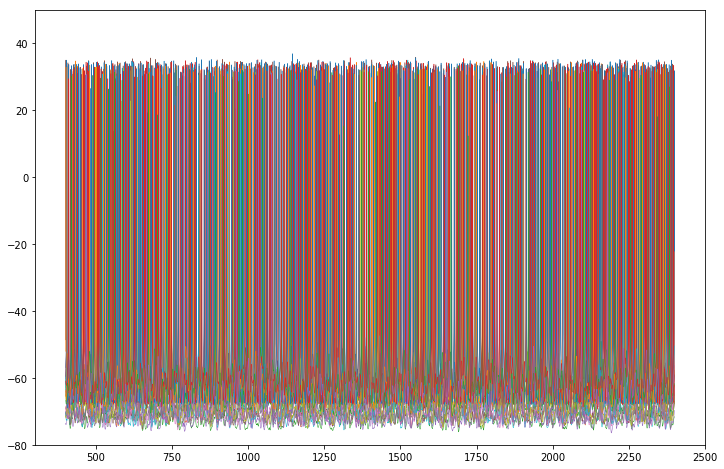

In [9]:
plt.figure(figsize=(12,8))
plt.clf()

#plt.subplot(341)
plt.plot(Time,V_t[:,::5],lw=0.5)
plt.ylim(-80,50 ) 

In [ ]:
decimate=50;cutfreq=100
b,a=signal.bessel(4,cutfreq*2*dt/1000,btype='low')

freqs=np.arange(10,100,0.5)  #Desired frequencies
Periods=1/(freqs*(decimate*dt)/1000)    #Desired periods in sample untis
dScales=Periods/Wavelets.Morlet.fourierwl  #desired Scales

binsize = 0.5 # bin size for population activity in ms
tbase = np.arange(equil, Total/dt, binsize/dt) # raster time base in time points

kernel=signal.gaussian(10*2/binsize+1,2/binsize)
kernel/=np.sum(kernel)

### Sinapsis eléctrica
La sinapsis eléctrica (o _gap junction_) causa una corriente que es proporcional a la diferencia de voltaje entre las neuronas conectadas. Es siempre simétrica.

$$I_{i,k}^{GJ}=-I_{k,i}^{GJ}=g^{GJ}_{ik}(V_i-V_k)$$

In [ ]:
def HyB(y,t):
    v,asd,asr,ah,ar=y

    ad = 1/(1+np.exp(-zd*(v-V0d)))
    isd = rho*gsd*asd*(v - Ed)
    psr = (asr**2)/(asr**2+0.4**2)
    Imemb=isd + rho*gd*ad*(v - Ed) + rho*(gr*ar + gsr*psr)*(v-Er) \
                + rho*gh*ah*(v - Eh)+ rho*gl*(v - El)
    arinf = 1/(1+np.exp(-zr*(v-V0r)))
    asdinf = 1/(1+np.exp(-zsd*(v-V0sd)))
    ahinf= 1/(1+np.exp(-zh*(v-V0h)))

    Igj = np.sum(CM * Ggj * (v[:,None] - v),-1)

    Det=np.array([-Imemb - Igj,
                phi*(asdinf - asd)/tsd,
                phi*(-eta*isd - kappa*asr)/tsr,
                phi*(ahinf-ah)/th,
                phi*(arinf - ar)/tr])   
    return Det

#Parámetros de este Modelo 
gd = 2.5; gr = 2.8; gsd = 0.21; gsr = 0.28;
gl = 0.06; gh = 0.4;
V0d = -25; V0r = -25; zd = 0.25; zr = 0.25;tr = 2;
V0sd = -40; zsd = 0.11; tsd = 10;
eta = 0.014; kappa = 0.18; tsr = 35;
V0h= -85; zh = -0.14; th=125;
Ed = 50; Er = -90; El = -80; Eh = -30;

nnodes=25
pij=0.1
K=3

gsd=np.random.uniform(0.19,0.22,size=nnodes)
gsr=np.random.uniform(0.26,0.3,size=nnodes)

#Construccion de una red Small World (Watts-Strogatz)
CM = np.zeros((nnodes,nnodes))
CM[0,-1]=1
for i in range(nnodes):
    for d in range(1,K+1):
        CM[i,i-d]=1
    if np.random.uniform()<pij:
        r1=np.random.randint(i-nnodes+K,i-K)
        r2=np.random.randint(1,K+1)
        CM[i,r1]=1
        if K>=2:
            CM[i,i-r2]=0
CM = CM+CM.T  #La red se hace simétrica
CM = np.minimum(CM,np.ones_like(CM)) #A veces algunas entradas son 2
Ggj = 0.001

v=np.random.uniform(low=-70,high=-50,size=nnodes)
temp=36
#Luego calulamos el valor de las variables a ese voltaje
ad = 1/(1+np.exp(-zd*(v-V0d)));
ar = 1/(1+np.exp(-zr*(v-V0r)));
asd = 1/(1+np.exp(-zsd*(v-V0sd)));
ah= 1/(1+np.exp(-zh*(v-V0h)))
rho = 1.3**((temp-25.)/10)
phi = 3**((temp-25.)/10)
asr = -eta*rho*gsd*asd*(v - Ed)/kappa;
tempF=[rho,phi]

y=np.array([v,asd,asr,ah,ar])

Ttotal=3000
dt=0.05
time=np.arange(0,Ttotal,dt)

Y_t=np.zeros((len(time),nnodes)) #en este caso se va a grabar solo una variable (V)

for i,t in enumerate(time):
    Y_t[i]=y[0]
    y += dt*HyB(y,t)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(time,Y_t)
plt.subplot(122)
plt.imshow(CM,cmap='gray_r')
